In [1]:
# Model and performance evaluation
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# Standardize the data
from sklearn.preprocessing import StandardScaler

# Hyperparameter tuning
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin

# Data processing
import pandas as pd
import numpy as np

# Plot the findings
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import plotly.express as px


In [2]:
# Load your dataset
data = pd.read_csv(r'C:\Users\Archy\Desktop\ml\Project\Scripts\Data\BTC-USD.csv')
sentiment = pd.read_csv(r'C:\Users\Archy\Desktop\ml\Project\Scripts\Data\sentiment_means.csv')

# n_samples - gap - (test_size * n_splits) > 0
TEST_SIZE = 200
GAP_BETWEEN_TRAIN_AND_TEST = 0
SPLITS = 15
FEATURES = ['Close_Diff', 'Sentiment_Mean']
TARGET = 'Target'


In [3]:

data.shape

(3127, 7)

In [4]:

data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)

data['Target'] = data['Close'].shift(periods=-1)
data['Target_tmp'] = data['Target']
data['Target'].mask(data['Target_tmp'] >= data['Close'], 0, inplace=True)
data['Target'].mask(data['Target_tmp'] < data['Close'], 1, inplace=True)

data.drop(['Target_tmp'], axis=1, inplace=True)

data['Close_Diff'] = data['Close'].shift(periods=1)
data['Close_Diff'] = data['Close'] - data['Close_Diff']

data.dropna(inplace=True)

data['Date'] = pd.to_datetime(data['Date'])
sentiment['Date'] = pd.to_datetime(sentiment['Date'])
data.set_index('Date', inplace=True)

data = data.merge(sentiment, on='Date', how='left')


In [5]:
# Check the target value distribution
data['Target'].value_counts(normalize=True)

Target
0.0    0.5328
1.0    0.4672
Name: proportion, dtype: float64

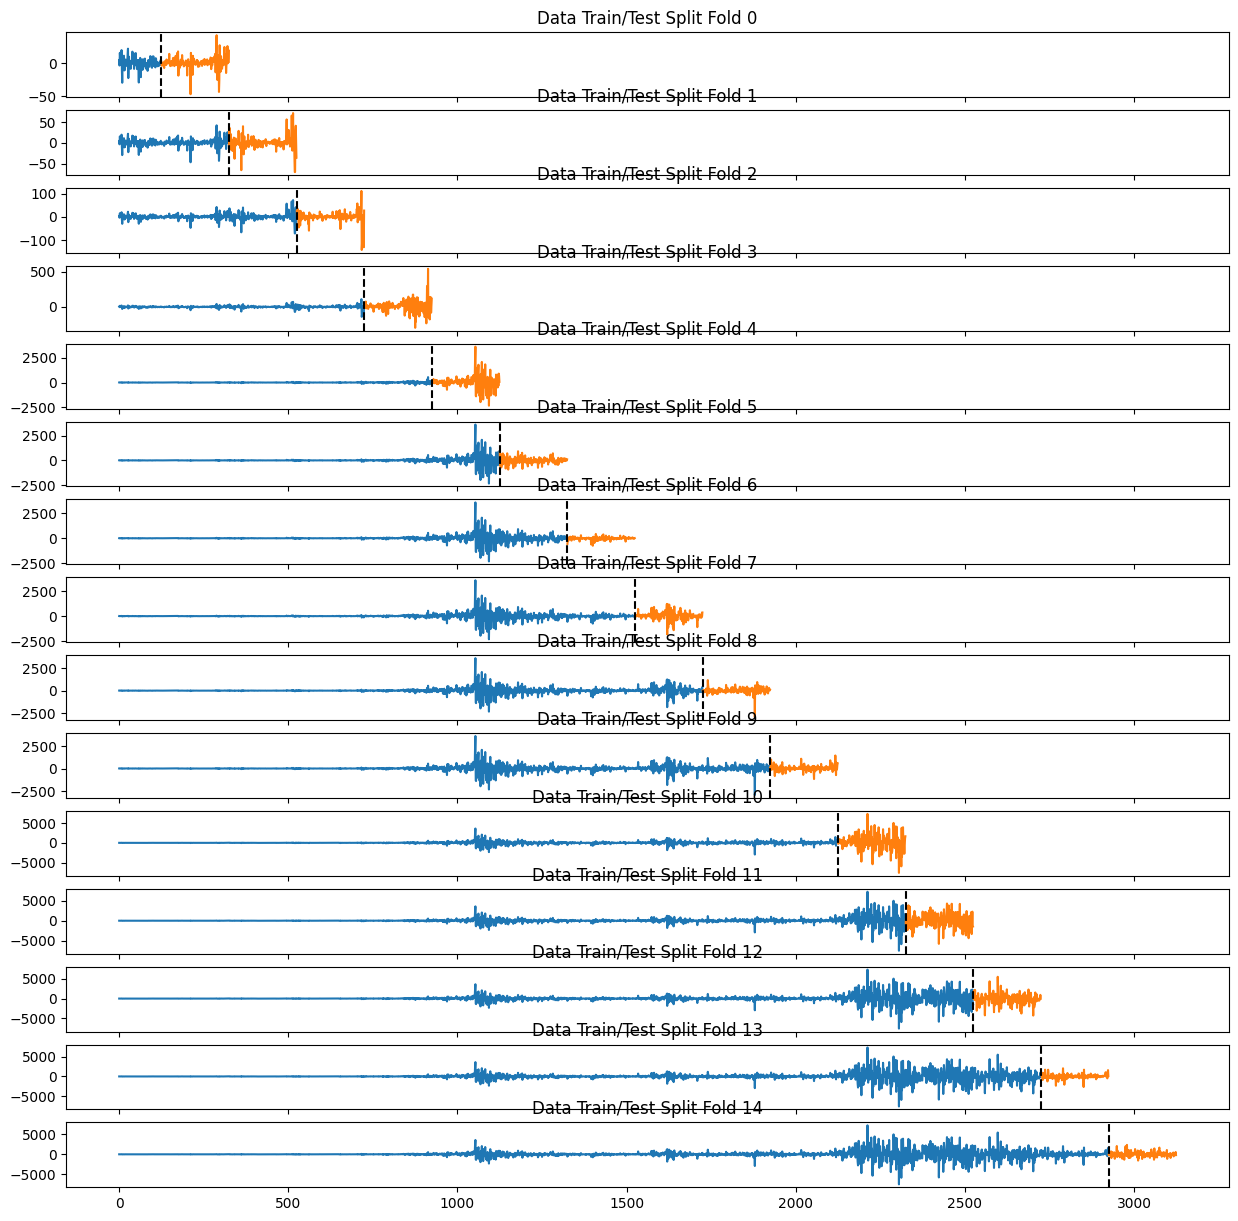

In [6]:
tss = TimeSeriesSplit(n_splits=SPLITS,
                      test_size=TEST_SIZE,
                      gap=GAP_BETWEEN_TRAIN_AND_TEST)

fig, axs = plt.subplots(SPLITS, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(data):
     train = data.iloc[train_idx]
     test = data.iloc[val_idx]
     train['Close_Diff'].plot(ax=axs[fold],
                              label='Training Set',
                              title=f'Data Train/Test Split Fold {fold}')
     test['Close_Diff'].plot(ax=axs[fold],
                             label='Test Set')
     axs[fold].axvline(test.index.min(), color='black', ls='--')
     fold += 1

plt.show()



In [7]:
# Initiate scaler
sc = StandardScaler()

all_params = []
all_losses = []
all_y_test = []
all_predictions = []

In [19]:
# Space
space = {
    'n_estimators': hp.choice('n_estimators', [500, 800, 1000, 1300, 1500]),
    'learning_rate': hp.choice('learning_rate', [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 3]),
    'max_depth' : hp.choice('max_depth', [1, 2, 3, 4, 5]),
    'subsample' : hp.choice('subsample', [0.6, 0.7, 0.8, 0.9, 1.0]),
    'gamma': hp.choice('gamma', [0, 0.1, 0.2, 0.3, 0.4, 0.5]),
    'colsample_bytree' : hp.choice('colsample_bytree', [i/10.0 for i in range(3,10)]),
    'colsample_bylevel' : hp.choice('colsample_bylevel', [i/10.0 for i in range(3,10)]),
    'reg_alpha' : hp.choice('reg_alpha', [10, 100]),
    'reg_lambda' : hp.choice('reg_lambda', [0.1, 1, 10])
}


In [20]:
# Objective function
def objective(params):
    # Initializations
    xgboost = XGBClassifier(objective='binary:logistic', seed=0, **params)
    scores = []
    params_log = []

    # Manually split data and compute scores
    for train_index, test_index in tss.split(data[FEATURES]):
        X_train, X_test = data[FEATURES].iloc[train_index], data[FEATURES].iloc[test_index]
        y_train, y_test = data[TARGET].iloc[train_index], data[TARGET].iloc[test_index]

        # Normalize features
        X_train = pd.DataFrame(sc.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
        X_test = pd.DataFrame(sc.transform(X_test), index=X_test.index, columns=X_test.columns)

        xgboost.fit(X_train, y_train)
        predictions = xgboost.predict(X_test)
        score = accuracy_score(y_test, predictions)
        scores.append(score)
        params_log.append(params)
        
        # Store the true labels and predictions for later use
        all_y_test.extend(y_test)
        all_predictions.extend(predictions)
        
    # Calculate mean score
    mean_score = np.mean(scores)

    # Loss is negative score
    loss = -mean_score

    all_params.append(params)
    all_losses.append(loss)

    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params_log, 'status': STATUS_OK}

In [21]:
# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 48, trials = Trials())

 46%|████▌     | 22/48 [03:25<04:45, 10.97s/trial, best loss: -0.5350000000000001]

In [ ]:
df = pd.DataFrame(all_params)
df['loss'] = all_losses
df['normalized_loss'] = (df['loss'] - df['loss'].min()) / (df['loss'].max() - df['loss'].min())

fig = px.parallel_coordinates(
    df,
    color="normalized_loss",
    labels={col: col for col in df.columns},
    color_continuous_scale=px.colors.diverging.Tealrose,
    color_continuous_midpoint=2
)

fig.show()

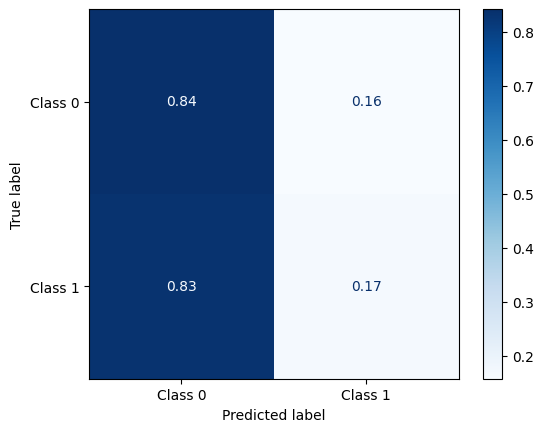

In [ ]:
cm = confusion_matrix(all_y_test, all_predictions)
# Normalize the confusion matrix to show percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)